In [15]:
pip install causalgraphicalmodels

Note: you may need to restart the kernel to use updated packages.


In [16]:
pip install statsmodels

Note: you may need to restart the kernel to use updated packages.


In [17]:
pip install networkx[default]

Note: you may need to restart the kernel to use updated packages.


In [ ]:
pip install pygraphviz

In [19]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from causalgraphicalmodels import CausalGraphicalModel
import networkx as nx
import matplotlib.pyplot as plt
import os

### Graph and simulate example 4 of Lab7 

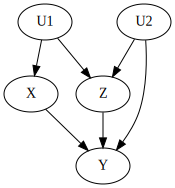

In [ ]:
dag4 = CausalGraphicalModel(
    nodes=["U1","U2", "Z", "X", "Y"],
    edges=[
        ("U1", "Z"), 
        ("U1", "X"),
        ("X", "Y"),
        ("Z", "Y"),
        ("U2", "Z"),
        ("U2", "Y")
    ]
)

dag4.draw()

In [21]:
np.random.seed(111)
n_samples = 100000

In [22]:
true_effect = 1

In [23]:
U1 = np.random.normal(size=n_samples)
U2 = np.random.normal(size=n_samples)

Z = 0.6 * U1 + 0.5 * U2 + np.random.normal(size=n_samples)
X = 0.8 * U1 + np.random.normal(size=n_samples)
Y = true_effect * X + 0.4 * Z + 0.9 * U2 + np.random.normal(size=n_samples) 

df = pd.DataFrame({'X': X, 'Y': Y, 'Z': Z})

In [24]:
pop_X = X.reshape(-1, 1)
pop_Y = Y.reshape(-1, 1)
pop_Z = Z.reshape(-1, 1)

In [25]:
#filtro para seleecionar muestra
sample_filter = np.random.uniform(0, 1, (n_samples, 1)) < 0.001
sample_indices = np.where(sample_filter)[0]
print(f"Número de muestras seleccionadas: {len(sample_indices)}")

Número de muestras seleccionadas: 93


### Regress Y vs. X with and without controlling for  Z


In [28]:
# Modelo 1: Y ~ X (sin constante)
model_sin_Z = sm.OLS(pop_Y[sample_indices], pop_X[sample_indices]).fit()
print("\n--- Regresión Final de Y vs. X (SIN constante) ---")
print(model_sin_Z.summary())


--- Regresión Final de Y vs. X (SIN constante) ---
                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.392
Model:                            OLS   Adj. R-squared (uncentered):              0.385
Method:                 Least Squares   F-statistic:                              59.26
Date:                Sat, 27 Sep 2025   Prob (F-statistic):                    1.52e-11
Time:                        15:55:38   Log-Likelihood:                         -179.64
No. Observations:                  93   AIC:                                      361.3
Df Residuals:                      92   BIC:                                      363.8
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025  

In [29]:
# Modelo 2: Y ~ X + Z (sin constante y con hstack)
model_con_Z = sm.OLS(
    pop_Y[sample_indices], 
    np.hstack((pop_X[sample_indices], pop_Z[sample_indices]))
).fit()
print("\n--- Regresión Final de Y vs. X (controlando pors Z y SIN constante) ---")
print(model_con_Z.summary())


--- Regresión Final de Y vs. X (controlando pors Z y SIN constante) ---
                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.573
Model:                            OLS   Adj. R-squared (uncentered):              0.564
Method:                 Least Squares   F-statistic:                              61.06
Date:                Sat, 27 Sep 2025   Prob (F-statistic):                    1.53e-17
Time:                        15:55:41   Log-Likelihood:                         -163.19
No. Observations:                  93   AIC:                                      330.4
Df Residuals:                      91   BIC:                                      335.4
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t    

### Plot your coefficients associated with  X in a single graph like in Part 2. Add this time a horizontal line indicating the true causal effect

In [ ]:
#  modelos para el gráfico
model_names = ['Y vs. X', 'Y vs. X, Z']

# Coeficientes de X de cada modelo
coefficients = [
    model_sin_Z.params[0],          # Coeficiente de X en el primer modelo
    model_con_Z.params[0]              # Coeficiente de X en el segundo modelo
]

# Intervalos de confianza al 99%
conf_intervals = [
    model_sin_Z.conf_int(alpha=0.01)[0],
    model_con_Z.conf_int(alpha=0.01)[0]
]

# Calculo los errores para el gráfico 
errors = [
    coefficients[0] - conf_intervals[0][0],
    coefficients[1] - conf_intervals[1][0]
]


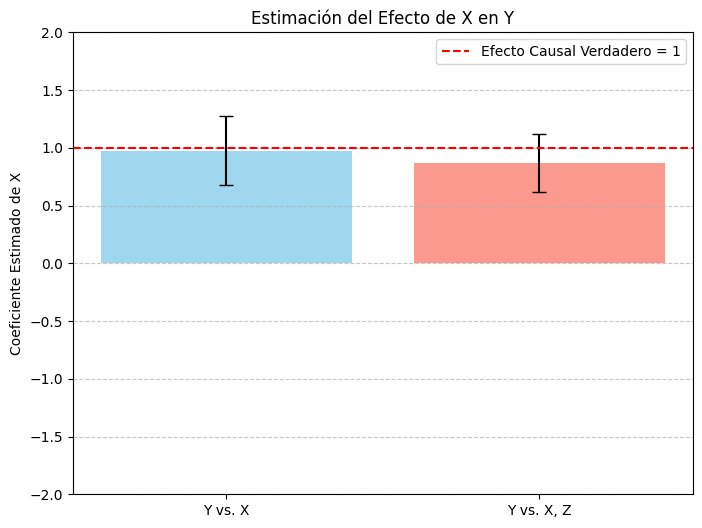

In [ ]:
plt.figure(figsize=(8, 6))

# Gráfico de barras con los errores
plt.bar(model_names, coefficients, yerr=errors, capsize=5, color=['skyblue', 'salmon'], alpha=0.8)

# Línea horizontal para el efecto causal verdadero
plt.axhline(y=true_effect, color='r', linestyle='--', label=f'Efecto Causal Verdadero = {true_effect}')

# Títulos y etiquetas
plt.title('Estimación del Efecto de X en Y')
plt.ylabel('Coeficiente Estimado de X')
plt.ylim(-2, 2) # Ajustar el eje Y para una mejor visualización
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Guardar el gráfico en la carpeta 'output'
os.makedirs('output', exist_ok=True)
plt.savefig('output/part3_coefficients_plot.png')

# Mostrar el gráfico
plt.show()


### Modify the DAG so z also has an effct on X

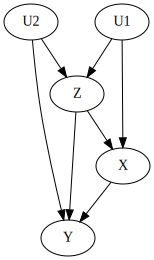

In [31]:
# Nuevo DAG con la nueva relación Z -> X
dag_2 = CausalGraphicalModel(
    nodes=["U1", "U2", "X", "Y", "Z"],
    edges=[
        ("U1", "X"), ("U1", "Z"),
        ("U2", "Y"), ("U2", "Z"),
        ("X", "Y"),  ("Z", "Y"),
        ("Z", "X")  # The new causal path
    ]
)

# Draw the modified graph
dag_2.draw()

In [32]:
# U1 y U2 ahora son observables
U1 = np.random.normal(size=n_samples)
U2 = np.random.normal(size=n_samples)

# valor de Z depende de U1 y U2
Z = 1 * U1 + 1 * U2 + np.random.normal(size=n_samples)

# X's value now depends on U1 AND Z
X = 1 * U1 + 1 * Z + np.random.normal(size=n_samples)

# Y's  depends de X, Z, U2
Y = 1 * X + 1 * Z + 1 * U2 + np.random.normal(size=n_samples)

# Create a DataFrame with all 5 observable variables
df_modified = pd.DataFrame({
    'X': X, 'Y': Y, 'Z': Z, 'U1': U1, 'U2': U2
})

df_modified.head()

,X,Y,Z,U1,U2
0,1.364827,4.528490,1.870947,-0.200022,1.251208
1,2.427789,2.882885,0.833774,0.923275,0.117520
2,-3.555713,-9.767297,-2.673743,0.262593,-1.826011
3,2.955952,6.012906,2.055761,0.166883,0.282353
4,0.973121,0.044354,-0.962310,-0.212177,0.258008


In [37]:
# (El código de la simulación de la respuesta anterior se asume ya ejecutado)
# df_modified ya existe y contiene X, Y, Z, U1, U2

# --- Regresiones con todas las combinaciones de controles ---

# Almacenaremos los resultados aquí para verlos fácilmente
results = {}

# 1. Sin controles
model_1 = sm.OLS(df_modified['Y'], df_modified['X']).fit()
results['Y ~ X'] = model_1.params['X']

# 2. Controlando por Z
model_2 = sm.OLS(df_modified['Y'], df_modified[['X', 'Z']]).fit()
results['Y ~ X + Z'] = model_2.params['X']

# 3. Controlando por U1
model_3 = sm.OLS(df_modified['Y'], df_modified[['X', 'U1']]).fit()
results['Y ~ X + U1'] = model_3.params['X']

# 4. Controlando por U2
model_4 = sm.OLS(df_modified['Y'], df_modified[['X', 'U2']]).fit()
results['Y ~ X + U2'] = model_4.params['X']

# 5. Controlando por Z y U1
model_5 = sm.OLS(df_modified['Y'], df_modified[['X', 'Z', 'U1']]).fit()
results['Y ~ X + Z + U1'] = model_5.params['X']

# 6. Controlando por Z y U2
model_6 = sm.OLS(df_modified['Y'], df_modified[['X', 'Z', 'U2']]).fit()
results['Y ~ X + Z + U2'] = model_6.params['X']

# 7. Controlando por U1 y U2
model_7 = sm.OLS(df_modified['Y'], df_modified[['X', 'U1', 'U2']]).fit()
results['Y ~ X + U1 + U2'] = model_7.params['X']

# 8. Controlando por Z, U1 y U2
model_8 = sm.OLS(df_modified['Y'], df_modified[['X', 'Z', 'U1', 'U2']]).fit()
results['Y ~ X + Z + U1 + U2'] = model_8.params['X']

# Imprimir los resultados de forma clara
print(" Coeficiente de X en cada regresión ")
print(f"El efecto causal verdadero es {true_effect}")
for model, coef in results.items():
    print(f"{model:<25}: {coef:.4f}")

 Coeficiente de X en cada regresión 
El efecto causal verdadero es 1
Y ~ X                    : 1.7112
Y ~ X + Z                : 0.8001
Y ~ X + U1               : 1.9981
Y ~ X + U2               : 1.4988
Y ~ X + Z + U1           : 0.9985
Y ~ X + Z + U2           : 1.0000
Y ~ X + U1 + U2          : 1.5036
Y ~ X + Z + U1 + U2      : 1.0015


In [38]:
models = [model_1, model_2, model_3, model_4, model_5, model_6, model_7, model_8]
row_names = [
    'None',
    'Z',
    'U1',
    'U2',
    'Z, U1',
    'Z, U2',
    'U1, U2',
    'Z, U1, U2'
]

# 2. Extraer el coeficiente (β) y el error estándar (SE) de X para cada modelo
results_data = []
for model in models:
    # model.params['X'] nos da el coeficiente de X
    beta = model.params['X']
    # model.bse['X'] nos da el error estándar de X
    se = model.bse['X']
    results_data.append({'β': beta, 'SE': se})

# 3. Crear el DataFrame final con los nombres de columna y fila correctos
results_df = pd.DataFrame(results_data, index=row_names)
results_df.index.name = 'Controls' # Le damos un nombre a la columna del índice

# 4. Presentar la tabla en pantalla y exportarla

print("--- Tabla de Resultados: Efecto Estimado de X en Y ---")
print(f"El efecto causal verdadero es: {true_effect}\n")
print(results_df)

# [cite_start]Exportar la tabla a un archivo .txt en la carpeta /output [cite: 75]
# .to_string() crea una versión de texto bien formateada de la tabla
os.makedirs('output', exist_ok=True)
results_df.to_string(open('output/regression_results.txt', 'w'))

print("\n✅ La tabla de resultados ha sido exportada a 'output/regression_results.txt'")


--- Tabla de Resultados: Efecto Estimado de X en Y ---
El efecto causal verdadero es: 1

                  β        SE
Controls                     
None       1.711163  0.002222
Z          0.800070  0.003085
U1         1.998149  0.003163
U2         1.498795  0.001586
Z, U1      0.998532  0.003872
Z, U2      0.999991  0.002579
U1, U2     1.503629  0.002735
Z, U1, U2  1.001493  0.003166

✅ La tabla de resultados ha sido exportada a 'output/regression_results.txt'


### Based on your findings, in what way(s) can you get a good estimate of the causal effect? 

In [ ]:
tolerance = 0.02

# Lista para guardar los nombres de los conjuntos de controles que funcionan
good_control_sets = []

# Iteramos sobre cada fila de nuestra tabla de resultados
for control_set, row in results_df.iterrows():
    beta_estimate = row['β']
    
    # Comprobamos si el coef esta dentro de la tolerancia
    if abs(beta_estimate - true_effect) < tolerance:
        good_control_sets.append(control_set)


print("--- Análisis de Resultados ---")
print(f"Efecto Causal Verdadero: {true_effect}")
print(f"Tolerancia para una buena estimación: +/- {tolerance}\n")

if good_control_sets:
    print(" Se encontró una buena estimación del efecto causal controlando por los siguientes conjuntos de variables:")
    for item in good_control_sets:
        print(f"   - {{{item}}}")
else:
    print(" Ninguno de los modelos produjo una estimación dentro de la tolerancia especificada.")


--- Análisis de Resultados ---
Efecto Causal Verdadero: 1
Tolerancia para una 'buena' estimación: +/- 0.02

 Se encontró una buena estimación del efecto causal controlando por los siguientes conjuntos de variables:
   - {Z, U1}
   - {Z, U2}
   - {Z, U1, U2}


### What is the minimal sufficient set of controls to get a good estimate? 


In [46]:
#se puede observar que el minimo seria solo usar 2 controles {Z, U1} o {Z, U2}

#si lo queremos hacer automatico, se resuelve de esta manera:
# Convertimos los nombres de los conjuntos buenos en sets para facilitar la comparación
good_sets_as_sets = []
for item in good_control_sets:
    if item == 'None':
        good_sets_as_sets.append(set())
    else:
        # Separamos el texto por la coma y el espacio para obtener las variables individuales
        variables = set(item.split(', '))
        good_sets_as_sets.append(variables)

# Lista para guardar los conjuntos que determinemos que son mínimos
minimal_sufficient_sets = []

# Iteramos sobre cada conjunto bueno para ver si es mínimo
for current_set in good_sets_as_sets:
    is_minimal = True
    # Comparamos el conjunto actual con todos los demás conjuntos buenos
    for other_set in good_sets_as_sets:
        # Si encontramos otro conjunto que es un subconjunto propio del actual,
        # entonces el actual no puede ser mínimo.
        if other_set != current_set and other_set.issubset(current_set):
            is_minimal = False
            break # No necesitamos seguir buscando, ya sabemos que no es mínimo
    
    # Si después de comparar con todos los demás, no se encontró un subconjunto, es mínimo
    if is_minimal:
        minimal_sufficient_sets.append(current_set)

# --- Imprimir el resultado final ---

print("--- Análisis de Conjuntos Mínimos Suficientes ---\n")
if minimal_sufficient_sets:
    print(" El conjunto(s) mínimo(s) suficiente(s) de controles para obtener una buena estimación es/son:")
    for min_set in minimal_sufficient_sets:
        # Se muestra un formato amigable si el conjunto está vacío
        if not min_set:
            print("   - {None}")
        else:
            print(f"   - {sorted(list(min_set))}") # sorted() para un orden consistente
else:
    print(" No se encontraron conjuntos de controles suficientes en el análisis.")


--- Análisis de Conjuntos Mínimos Suficientes ---

 El conjunto(s) mínimo(s) suficiente(s) de controles para obtener una buena estimación es/son:
   - ['U1', 'Z']
   - ['U2', 'Z']


### Provide intuition on why you can get good estimates controlling for the variables you stablished above

{Z, U1} es un buen control porque cierra todos los caminos espurios originales y, crucialmente, también neutraliza el nuevo camino espurio que se genera al controlar por el collider. La misma lógica aplica para el conjunto {Z, U2}.